# Load libraries

In [33]:

from cobra.flux_analysis import flux_variability_analysis
from cobra.io import read_sbml_model
import cobra
import numpy as np
import networkx as nx
from dingo.illustrations import plot_graph
from cobra.flux_analysis.loopless import loopless_solution

import matplotlib.pyplot as plt

# Load model, solve with FBA and create duplicate models for modification

In [3]:
ec_model = read_sbml_model('../../ext_data/e_coli_core.xml')
reaction_list = ec_model.reactions

# Solve the model with the default constraints
solution = ec_model.optimize()
print(solution.objective_value)
print(solution.get_primal_by_id("FRD7"))
print(solution.get_primal_by_id("SUCDi"))

# Create duplicate models, to later add constraints
ec_model_loopless_fva = ec_model.copy()
ec_model_loopless_fva_FRD7 = ec_model.copy()
ec_model_loopless_fva_FRD7_SUCDi = ec_model.copy()

Set parameter Username
Set parameter LicenseID to value 2634947
Academic license - for non-commercial use only - expires 2026-03-11
0.8739215069684302
0.0
5.064375661482091
Read LP format model from file /tmp/tmpa3mpkuzi.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmp6l0xz29d.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmpmur3rw_g.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


# Perform default and loopless FVA

In [4]:

# Define the fraction of the optimum to be used for FVA 
fraction_of_optimum = 1

# Perform default FVA on the model
fva = flux_variability_analysis(ec_model, 
                                loopless=False,
                                fraction_of_optimum=fraction_of_optimum)
fva_dict = fva.apply(lambda row: (row['minimum'], row['maximum']), axis=1).to_dict()

# Perform loopless FVA on the model
fva_loopless = flux_variability_analysis(ec_model, 
                                         loopless=True,
                                         fraction_of_optimum=fraction_of_optimum)
fva_loopless_dict = fva_loopless.apply(lambda row: (row['minimum'], row['maximum']), axis=1).to_dict()


# Modify the duplicate models based on the loopless FVA solution

In [37]:

# Define the number of decimal places to round the bounds to, to avoid errors when setting the bounds in the model
rounding = 10
# Define a tolerance for the bounds. This is to avoid infeasibility due to rounding errors when setting the bounds in the model
tol = 1e-10


# Constrain the model to the loopless FVA solution (all reactions)
for reaction in reaction_list:
    model_reaction = ec_model_loopless_fva.reactions.get_by_id(reaction.id)
    model_reaction.upper_bound = (round(fva_loopless_dict[reaction.id][1], rounding)) + tol
    model_reaction.lower_bound = (round(fva_loopless_dict[reaction.id][0], rounding)) - tol

print("Constrained model to the loopless solution of all reactions")
solution = ec_model_loopless_fva.optimize()
print(solution.objective_value)
print("FRD7:" , solution.get_primal_by_id("FRD7"))
print("SUCDi:", solution.get_primal_by_id("SUCDi"))


Constrained model to the loopless solution of all reactions
0.8739215069930292
FRD7: -1e-10
SUCDi: 5.064375661485151


In [ ]:
# Constrain the model to the loopless solution of FRD7
for reaction in reaction_list:
    if reaction.id == "FRD7":
        model_reaction = ec_model_loopless_fva_FRD7.reactions.get_by_id(reaction.id)
        model_reaction.upper_bound = fva_loopless_dict[reaction.id][1]
        model_reaction.lower_bound = fva_loopless_dict[reaction.id][0]

print("\n\nConstrained model to loopless solution of FRD7")
solution = ec_model_loopless_fva_FRD7.optimize()
print(solution.objective_value)
print("FRD7:", solution.get_primal_by_id("FRD7"))
print("SUCDi:", solution.get_primal_by_id("SUCDi"))


In [38]:
# Constrain the model to the loopless solution of both FRD7 and SUCDi
for reaction in reaction_list:
    if reaction.id == "FRD7" or reaction.id == "SUCDi":
        model_reaction = ec_model_loopless_fva_FRD7_SUCDi.reactions.get_by_id(reaction.id)
        model_reaction.upper_bound = fva_loopless_dict[reaction.id][1]
        model_reaction.lower_bound = fva_loopless_dict[reaction.id][0]

print("\n\nConstrained model to loopless solution of FRD7 and SUCDi")
solution = ec_model_loopless_fva_FRD7_SUCDi.optimize()
print(solution.objective_value)
print("FRD7:", solution.get_primal_by_id("FRD7"))
print("SUCDi:", solution.get_primal_by_id("SUCDi"))



Constrained model to loopless solution of FRD7 and SUCDi
0.8739215069684309
FRD7: 0.0
SUCDi: 5.064375661482165


# Perform sampling on the default and modified models

In [44]:
# Completed
sampler_ec_model = cobra.sampling.optgp.OptGPSampler(ec_model)
samples_ec_model = sampler_ec_model.sample(n=1000)
samples_ec_model = samples_ec_model.to_numpy().T


# ValueError: Flux cone only consists a single point.
#sampler_ec_model_loopless_fva = cobra.sampling.optgp.OptGPSampler(ec_model_loopless_fva)
#samples_ec_model_loopless_fva = sampler_ec_model_loopless_fva.sample(n=1000)
#samples_ec_model_loopless_fva = samples_ec_model_loopless_fva.to_numpy().T


# Completed
sampler_ec_model_loopless_fva_FRD7 = cobra.sampling.optgp.OptGPSampler(ec_model_loopless_fva_FRD7)
samples_ec_model_loopless_fva_FRD7 = sampler_ec_model_loopless_fva_FRD7.sample(n=1000)
samples_ec_model_loopless_fva_FRD7 = samples_ec_model_loopless_fva_FRD7.to_numpy().T


# Completed
sampler_ec_model_loopless_fva_FRD7_SUCDi = cobra.sampling.optgp.OptGPSampler(ec_model_loopless_fva_FRD7_SUCDi)
samples_ec_model_loopless_fva_FRD7_SUCDi = sampler_ec_model_loopless_fva_FRD7_SUCDi.sample(n=1000)
samples_ec_model_loopless_fva_FRD7_SUCDi = samples_ec_model_loopless_fva_FRD7_SUCDi.to_numpy().T



Read LP format model from file /tmp/tmp1flm21e_.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


Read LP format model from file /tmp/tmpeqd8jbfw.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmp6ln725zr.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


In [45]:
FRD7_index = reaction_list.index("FRD7")
SUCDi_index = reaction_list.index("SUCDi")

# Print statistics for the samples of FRD7 across the different constained models
print("Mean value from samples of FRD7 across the different models")
print("Initial model:", np.mean(samples_ec_model[FRD7_index]))
print("Fixed FRD7", np.mean(samples_ec_model_loopless_fva_FRD7[FRD7_index]))
print("Fixed FRD7and SUCDi", np.mean(samples_ec_model_loopless_fva_FRD7_SUCDi[FRD7_index]))

# Print statistics for the samples of SUCDi across the different constained models
print("\nMean value from samples of SUCDi across the different models")
print("Initial model:", np.mean(samples_ec_model[SUCDi_index]))
print("Fixed FRD7", np.mean(samples_ec_model_loopless_fva_FRD7[SUCDi_index]))
print("Fixed FRD7and SUCDi",np.mean(samples_ec_model_loopless_fva_FRD7_SUCDi[SUCDi_index]))


Mean value from samples of FRD7 across the different models
Initial model: 521.2989689064401
Fixed FRD7 0.0
Fixed FRD7and SUCDi 0.0

Mean value from samples of SUCDi across the different models
Initial model: 527.8875904129619
Fixed FRD7 6.949928117422179
Fixed FRD7and SUCDi 5.064375661482103


# Calculate the FBA loopless solution

In [8]:
cobra_reactions_str = [str(reaction.id) for reaction in reaction_list]

# Calculate the loopless solution for the default model
loopless = loopless_solution(model = ec_model)
print(loopless.fluxes)


PFK         7.477382
PFL         0.000000
PGI         4.860861
PGK       -16.023526
PGL         4.959985
             ...    
NADH16     38.534610
NADTRHD     0.000000
NH4t        4.765319
O2t        21.799493
PDH         9.282533
Name: fluxes, Length: 95, dtype: float64


In [25]:
# Calculate the FBA loopless solution for the samples of the default model
fluxes_dict = dict(zip(cobra_reactions_str, samples_ec_model[0]))
loopless = loopless_solution(model = ec_model, fluxes = fluxes_dict)
print(loopless.objective_value)
#print(loopless.fluxes)


-24.95462063174318


/opt/miniconda3/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [ ]:
# Calculate the FBA loopless solution for the samples of the model constrained to the FVA loopless solution of FRD7
fluxes_dict = dict(zip(cobra_reactions_str, samples_ec_model_loopless_fva_FRD7[0]))
loopless = loopless_solution(model = ec_model_loopless_fva_FRD7, fluxes = fluxes_dict)
print(loopless.objective_value)
#print(loopless.fluxes)


In [27]:
fluxes_dict = dict(zip(cobra_reactions_str, samples_ec_model[0]))
loopless = loopless_solution(model = ec_model, fluxes = fluxes_dict)
print(loopless.objective_value)



-24.6687740036379


In [46]:
loopless_solutions = []
for sol in samples_ec_model.T:
    
    fluxes = {k:v for k,v in zip(cobra_reactions_str, sol)}
    
    loopless_sol = loopless_solution(model=ec_model, fluxes=fluxes)
    
    loopless_solutions.append(loopless_sol)


/opt/miniconda3/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [22]:
cobra_reactions_str.index("BIOMASS_Ecoli_core_w_GAM")

24

In [47]:
loopless_obj = []
for sol in loopless_solutions:
    loopless_obj.append(sol.objective_value)

(array([380., 269., 154.,  92.,  54.,  24.,  18.,   6.,   6.,   2.]),
 array([2.74015320e-06, 2.21722167e-02, 4.43416932e-02, 6.65111697e-02,
        8.86806463e-02, 1.10850123e-01, 1.33019599e-01, 1.55189076e-01,
        1.77358552e-01, 1.99528029e-01, 2.21697505e-01]),
 <BarContainer object of 10 artists>)

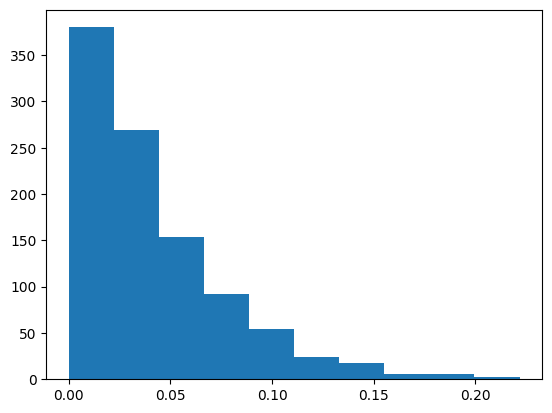

In [48]:
plt.hist(loopless_obj)

(array([ 15.,  48.,  90., 169., 195., 207., 156.,  79.,  29.,  17.]),
 array([11.67681249, 15.22319714, 18.7695818 , 22.31596645, 25.8623511 ,
        29.40873576, 32.95512041, 36.50150507, 40.04788972, 43.59427437,
        47.14065903]),
 <BarContainer object of 10 artists>)

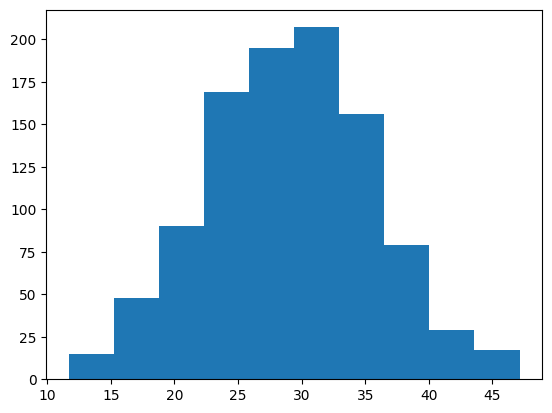

In [66]:
cobra_reactions_str.index("EX_co2_e")

co2_fluxes = []
for sol in loopless_solutions:
   
    co2_fluxes.append(sol.to_frame()["fluxes"]["EX_co2_e"])

plt.hist(co2_fluxes)

In [56]:
sol

<Solution infeasible at 0x79888a784470>

# Visualize network with graphs

In [14]:

correlation_matrix_ec_model = np.corrcoef(samples_ec_model)
correlation_matrix_ec_model[np.isnan(correlation_matrix_ec_model)] = 0
print(correlation_matrix_ec_model.shape)


correlation_matrix_ec_model_loopless_fva_FRD7 = np.corrcoef(samples_ec_model_loopless_fva_FRD7)
correlation_matrix_ec_model_loopless_fva_FRD7[np.isnan(correlation_matrix_ec_model_loopless_fva_FRD7)] = 0
print(correlation_matrix_ec_model_loopless_fva_FRD7.shape)


correlation_matrix_ec_model_loopless_fva_FRD7_SUCDi = np.corrcoef(samples_ec_model_loopless_fva_FRD7_SUCDi)
correlation_matrix_ec_model_loopless_fva_FRD7_SUCDi[np.isnan(correlation_matrix_ec_model_loopless_fva_FRD7_SUCDi)] = 0
print(correlation_matrix_ec_model_loopless_fva_FRD7_SUCDi.shape)



def graphs(correlation_matrix, reactions, correction=True):
       
    graph_matrix = correlation_matrix.copy()
    np.fill_diagonal(graph_matrix, 0)
    
    if correction == True:
        graph_matrix = abs(graph_matrix)
        
    G = nx.from_numpy_array(graph_matrix)
    G = nx.relabel_nodes(G, lambda x: reactions[x])
    
    pos = nx.spring_layout(G)
    unconnected_nodes = list(nx.isolates(G))
    G.remove_nodes_from(unconnected_nodes)
    
    center_x = np.mean([p[0] for p in pos.values()])
    center_y = np.mean([p[1] for p in pos.values()])
    central_nodes = [node for node, (x, y) in pos.items() if abs(x - center_x) < 0.2 and abs(y - center_y) < 0.2]
    
    return G, pos, central_nodes
    


cobra_reactions_str = [str(reaction.id) for reaction in reaction_list]



G_ec_model, layout_ec_model, central_nodes_ec_model  = graphs(correlation_matrix_ec_model,
                reactions = cobra_reactions_str,
                correction=True
                )
plot_graph(G_ec_model, layout_ec_model)



G_ec_model_loopless_fva_FRD7, layout_ec_mode_loopless_fva_FRD7, central_nodes_ec_model_loopless_fva_FRD7  = graphs(correlation_matrix_ec_model_loopless_fva_FRD7,
                reactions = cobra_reactions_str,
                correction=True
                )
plot_graph(G_ec_model_loopless_fva_FRD7, layout_ec_mode_loopless_fva_FRD7)



G_ec_model_loopless_fva_FRD7_SUCDi, layout_ec_mode_loopless_fva_FRD7_SUCDi, central_nodes_ec_model_loopless_fva_FRD7_SUCDi  = graphs(correlation_matrix_ec_model_loopless_fva_FRD7_SUCDi,
                reactions = cobra_reactions_str,
                correction=True
                )
plot_graph(G_ec_model_loopless_fva_FRD7_SUCDi, layout_ec_mode_loopless_fva_FRD7_SUCDi)




/home/touliopoulos/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/touliopoulos/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(95, 95)
(95, 95)
(95, 95)
